## IMPORTS

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN


## DATASET

In [ ]:
df = pd.read_csv("roi_features_train.csv")

X = df.drop(columns=["image_id", "score", "x1", "y1", "x2", "y2", "label"])
y = df["label"]
X



In [18]:
y

53       2
60       2
61       2
150      5
151      4
        ..
73375    2
73396    2
73401    6
73444    2
73504    2
Name: label, Length: 2537, dtype: int64

## CLEAR DATASET

In [20]:
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Shape originale: {df.shape}, shape pulita: {df_clean.shape}")

# Aggiorna X e y con il dataset pulito
X = df_clean.drop(columns=["image_id", "score", "x1", "y1", "x2", "y2", "label"])
y = df_clean["label"]

# remove class 1
X = X[y != 1]
y = y[y != 1]

Shape originale: (73508, 1031), shape pulita: (73508, 1031)


## TRAIN/TEST SPLIT

Distribuzione Classi:
 label
2    1072
4     350
3     274
5     141
6     114
7      78
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribuzione delle classi')

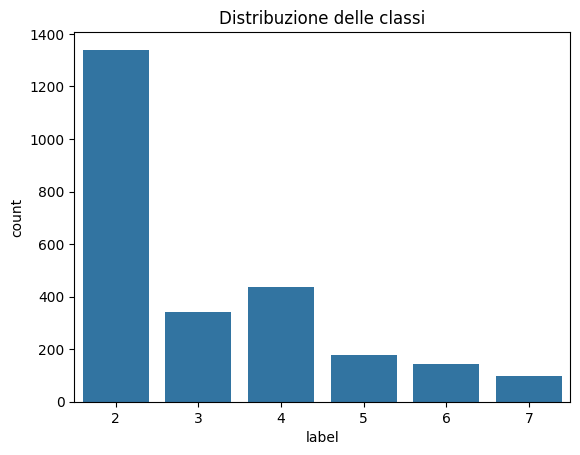

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sns.countplot(x=y)
print("Distribuzione Classi:\n", pd.Series(y_train).value_counts())

plt.title("Distribuzione delle classi")


## LABEL ENCODER

In [22]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

## PCA

In [32]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"🔍 PCA ha ridotto le dimensioni da {X.shape[1]} a {X_train_pca.shape[1]}")

X_train_pca = X_train
X_test_pca = X_test

🔍 PCA ha ridotto le dimensioni da 1024 a 49


## SMOTE

✅ SMOTE: minority class count = 78, using k_neighbors = 5
Distribuzione post-SMOTE:
 0    1072
1    1072
5    1072
3    1072
2    1072
4    1072
Name: count, dtype: int64


<Axes: ylabel='count'>

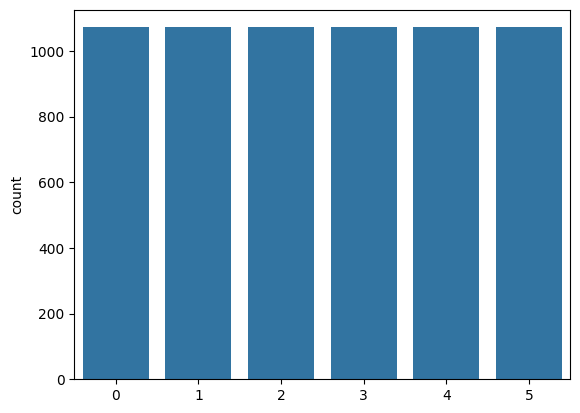

In [37]:

# == MOTE genera nuovi esempi sintetici per le classi poco rappresentate. ==

# Calcola k_neighbors dinamicamente
minority_class_count = Counter(y_train_encoded).most_common()[-1][1]
k = max(1, min(5, minority_class_count - 1))  # k <= n_minority - 1

print(f"✅ SMOTE: minority class count = {minority_class_count}, using k_neighbors = {k}")

# Applica SMOTE
smote = SMOTE(random_state=42, k_neighbors=k)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train_encoded)


print("Distribuzione post-SMOTE:\n", pd.Series(y_train_bal).value_counts())
sns.countplot(x=y_train_bal)


## ADASYN

Distribuzione post-ADASYN:
 2    1163
1    1125
5    1082
0    1072
3    1049
4    1049
Name: count, dtype: int64


<Axes: ylabel='count'>

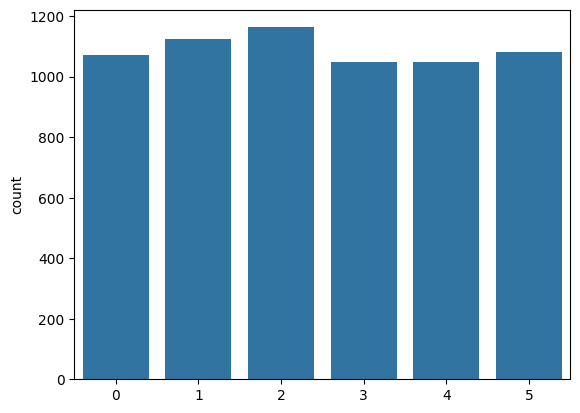

In [ ]:
# # Applica ADASYN
# adasyn = ADASYN(random_state=42)
# X_train_bal, y_train_bal = adasyn.fit_resample(X_train_pca, y_train_encoded)
# print("Distribuzione post-ADASYN:\n", pd.Series(y_train_bal).value_counts())
# sns.countplot(x=y_train_bal)

## MODELS

In [38]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, weights)}


models = {
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", scale_pos_weight=class_weight_dict),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000)
}



## CONFUSION MATRIX FUNC

In [39]:
def confusion_matrix_func(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## PIPELINES


🔹 Training SVM...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  41.3s
Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.72      0.60      0.65       268
           1       0.50      0.59      0.54        69
           2       0.27      0.29      0.28        87
           3       0.16      0.20      0.18        35
           4       0.15      0.24      0.19        29
           5       0.55      0.55      0.55        20

    accuracy                           0.50       508
   macro avg       0.39      0.41      0.40       508
weighted avg       0.53      0.50      0.51       508

Balanced Accuracy: 0.4122807998985582
Macro F1-score: 0.3986123048225781

🔹 Training XGBoost...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s


/home/achille/Desktop/ML/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:38:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Pipeline] ............... (step 2 of 2) Processing clf, total=  32.1s
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.66      0.85      0.75       268
           1       0.54      0.39      0.45        69
           2       0.32      0.29      0.30        87
           3       0.14      0.06      0.08        35
           4       0.30      0.10      0.15        29
           5       0.46      0.30      0.36        20

    accuracy                           0.57       508
   macro avg       0.41      0.33      0.35       508
weighted avg       0.52      0.57      0.54       508

Balanced Accuracy: 0.331666345221135
Macro F1-score: 0.35047879519082636

🔹 Training RandomForest...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.6s
Classification Report for RandomForest:

              precision    recall  f1-score   support

           

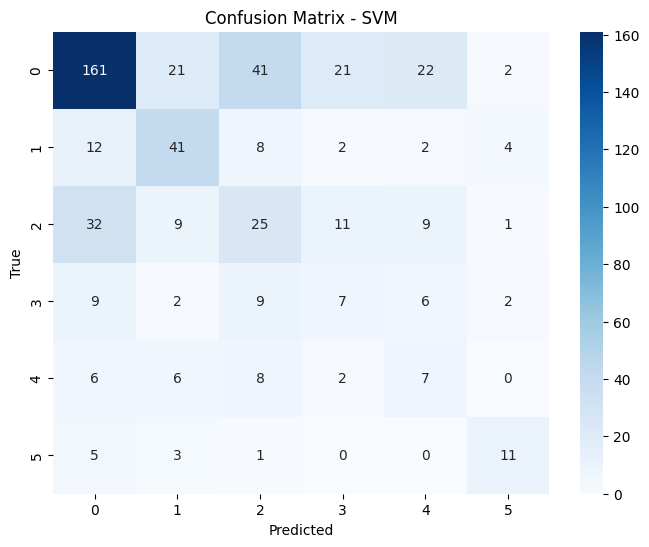

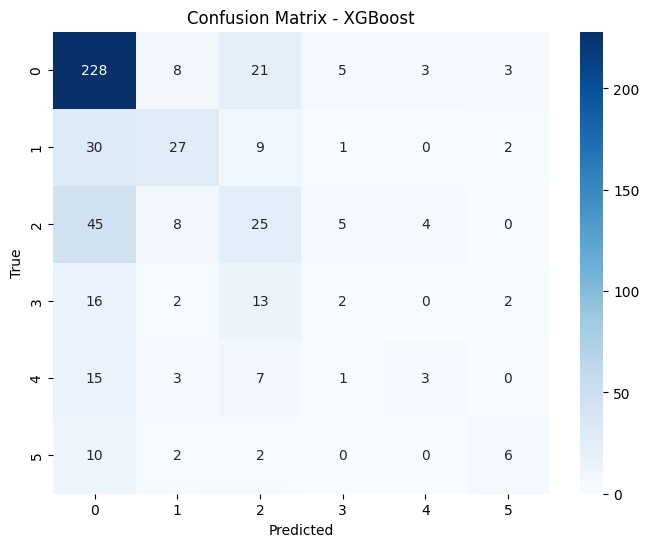

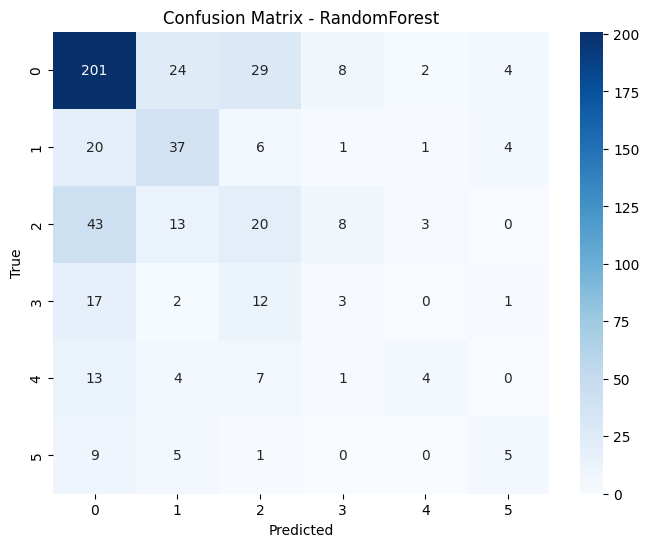

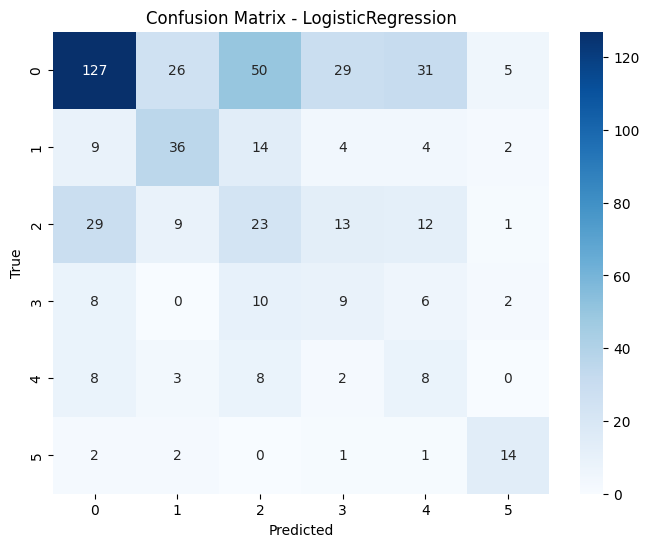

In [40]:

pipelines = {
    name: Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ], verbose=True)
    for name, model in models.items()
}

results = {}

for name, pipe in pipelines.items():
    # == TRAINING PHASE ==
    print(f"\n🔹 Training {name}...")
    pipe.fit(X_train_bal, y_train_bal)
    # == TEST PHASE ==
    y_pred = pipe.predict(X_test_pca)
    # == REPORT PHASE ==
    report = classification_report(y_test_encoded, y_pred, zero_division=0, output_dict=True)
    results[name] = {
        "pipeline": pipe,
        "report": report,
        "y_pred": y_pred
    }
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test_encoded, y_pred, zero_division=0))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred))
    print("Macro F1-score:", f1_score(y_test_encoded, y_pred, average='macro'))

# == CONFUSION MATRIX ==
for name, res in results.items():
    confusion_matrix_func(y_test_encoded, res["y_pred"], name)


## LOOP WITH PARAM GRID

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grids = {
#     # "SVM": {
#     #     'clf__C': [10],
#     #     'clf__gamma': ['scale',  0.1]
#     # },
#     # "RandomForest": {
#     #     'clf__n_estimators': [100],
#     #     'clf__max_depth': [20]
#     # },
#     # "XGBoost": {
#     #     'clf__n_estimators': [100, 200],
#     #     'clf__max_depth': [3, 5, 7],
#     #     'clf__learning_rate': [0.01, 0.1, 0.2]
#     # },
#     # "LogisticRegression": {
#     #     'clf__C': [10],
#     #     'clf__solver': ['saga']
#     # }
# }

# best_pipelines = {}
# for name, pipe in pipelines.items():
#     if name in param_grids:
#         print(f"\n🔍 GridSearchCV per {name}...")
#         grid = GridSearchCV(pipe, param_grids[name], scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
#         grid.fit(X_train_bal, y_train_bal)
#         best_pipelines[name] = grid.best_estimator_
#         print(f"Best params for {name}: {grid.best_params_}")
#     else:
#         pipe.fit(X_train_bal, y_train_bal)
#         best_pipelines[name] = pipe

# # Valutazione sui dati di test
# for name, pipe in best_pipelines.items():

#     y_pred = pipe.predict(X_test_pca)
#     print(f"\nClassification Report for {name} (best):")
#     print(classification_report(y_test_encoded, y_pred, zero_division=0))
#     print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred))
#     print("Macro F1-score:", f1_score(y_test_encoded, y_pred, average='macro'))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.0s

Classification Report for SVM (best):
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       268
           1       0.53      0.54      0.53        69
           2       0.29      0.28      0.28        87
           3       0.20      0.17      0.18        35
           4       0.23      0.17      0.20        29
           5       0.67      0.50      0.57        20

    accuracy                           0.55       508
   macro avg       0.43      0.40      0.41       508
weighted avg       0.53      0.55      0.54       508

Balanced Accuracy: 0.3978799335229329
Macro F1-score: 0.41204839237691965
